In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.distributions import Categorical
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch import nn
from collections import deque
import numpy as np
import random
import time
import warnings 
warnings.simplefilter('ignore')
seed = 6
torch.manual_seed(seed)

# model

In [2]:
class critic(nn.Module):
    ''' 
    input : state(vector)
    output : state_value(scalar)
    '''
    def __init__(self, input_dim):
        super(critic, self).__init__()
        self.fc1 = nn.Linear(input_dim,128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,1)

    def forward(self,state):
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        
        # Linear output
        return self.fc3(state)

class actor(nn.Module):
    '''
    input : state(vector) 
    output : action_probs(vector)
    '''
    def __init__(self, input_dim, output_dim):
        super(actor, self).__init__()
        self.fc1 = nn.Linear(input_dim,128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,output_dim)
    
    def forward(self, state):
        logits = F.relu(self.fc1(state))
        logits = F.relu(self.fc2(logits))
        
        # softmax output
        return F.softmax(self.fc3(logits),dim=1)

# agent

In [3]:
class PPOAgent(object):
    def __init__(
        self,
        env,
        gamma = 0.99,
        clip = 0.2,
        lr = 1e-3,
        K_epoch = 4):
        
        # common
        self.device = "cuda"
        self.env = env
        self.env.seed(42)
        self.obs_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        self.writer = SummaryWriter()
        
        # Hyperparamters
        self.gamma = gamma
        self.clip = clip
        self.lr = lr
        self.K_epoch = K_epoch
        
        # critic
        self.critic = critic(self.obs_dim).to(self.device)
        self.critic.apply(self._weights_init)
        
        # actor
        self.actor = actor(self.obs_dim,self.action_dim).to(self.device)
        self.actor.apply(self._weights_init)
        
        # optimizer
        self.critic_optimizer = optim.Adam(self.critic.parameters(),lr=lr)
        self.actor_optimizer = optim.Adam(self.actor.parameters(),lr=lr)
        
        # recorder
        self.recorder = {'a_loss':[],
                         'v_loss':[],
                         'e_loss':[],
                         'ratio':[]}
            
    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.01)
    
    def get_action(self,state,greedy = False):
        state = torch.FloatTensor([state]).to(self.device)
        probs = self.actor(state) # softmax_probs
        dist = Categorical(probs) # Categorical distribution
        act = dist.sample() # smaple action from this Categorical distribution
        return act.detach().item()
    
    def get_value(self,state):
        state = torch.FloatTensor([state]).to(self.device)
        value = self.critic(state)
        return value.item()
    
    def compute_returns(self,rewards):
        returns = []
        G = 0
        for r in rewards[::-1]:
            G = r + self.gamma*G
            returns.insert(0,G)
        returns = np.array([i for i in returns]).ravel()
        return torch.FloatTensor(returns).to(self.device).view(-1, 1)
    
    def preprocessing_img(self,img):
        return ((img / 255.0)-0.5)*2
    
    def update(self,trajectory):
        
        # get trajectory
        state = torch.FloatTensor([sars[0] for sars in trajectory]).to(self.device)
        action = torch.LongTensor([sars[1] for sars in trajectory]).to(self.device).view(-1, 1)
        rewards = [sars[2] for sars in trajectory]
        next_state = torch.FloatTensor([sars[3] for sars in trajectory]).to(self.device)
        done = torch.FloatTensor([sars[4] for sars in trajectory]).to(self.device).view(-1, 1)
        
        # get old_p
        old_p = torch.gather(self.actor(state),1,action).detach()
        
        # update K_epoch
        for _ in range(self.K_epoch):
            
            # calculate critic loss
            values = self.critic(state)
            returns = self.compute_returns(rewards)
            advantage = returns - values
            critic_loss = (advantage**2).mean()
            self.recorder['v_loss'].append(critic_loss.item())
            
            # calculate ratio new_p/old_P
            new_p = torch.gather(self.actor(state),1,action)
            ratio = new_p / old_p
            self.recorder['ratio'].append(ratio.mean().item())
            
            # surr and entropy loss
            surr1 = ratio * advantage.detach()
            surr2 = torch.clamp(ratio,1 - self.clip,1 + self.clip) * advantage.detach()
            entropy_loss = Categorical(self.actor(state)).entropy().mean()
            self.recorder['e_loss'].append(entropy_loss.item())
            
            # actor_loss
            actor_loss = -torch.min(surr1,surr2).mean() - 0.001 * entropy_loss
            self.recorder['a_loss'].append(actor_loss.item())
            
            # update critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
            
            # update actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
    
    def train(self,max_episodes):
        episode_rewards = []
        for episode in range(max_episodes):
            
            # initialize new game
            state = self.env.reset()
            state = self.preprocessing_img(state)
            trajectory = [] # [[s, a, r, s', done], [], ...]
            episode_reward = 0
            done = False
            
            # game loop
            while not done:
                self.env.render()
                action = self.get_action(state)
                
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocessing_img(next_state)
                
                trajectory.append([state, action, reward, next_state, done])
                episode_reward += reward
                state = next_state
            
            # game over 
            print("Episode " + str(episode) + ": " + str(episode_reward))
            episode_rewards.append(episode_reward)
            self.writer.add_scalar('EpisodeReward', episode_reward, episode)
            
            # evaluate agent 
            if episode_reward > 40:
                print('solved!')
                return episode_rewards
            
            else:
                self.update(trajectory)
                
        return episode_rewards
    
    def play(self,max_episodes):
        
        for episode in range(max_episodes):
            
            # initialize new game
            state = self.env.reset()
            state = self.preprocessing_img(state)
            
            episode_reward = 0
            done = False
            
            # game loop
            while not done:
                self.env.render()
                time.sleep(1/60)
                action = self.get_action(state)
                
                next_state, reward, done, _ = self.env.step(action)
                next_state = self.preprocessing_img(next_state)
                
                episode_reward += reward
                state = next_state
            
            # game over
            print("Episode " + str(episode) + ": " + str(episode_reward))
        
        self.env.close()

In [4]:
import gym

env = gym.make("Boxing-ram-v0")
env.seed(seed)

agent = PPOAgent(env)

history = agent.train(max_episodes=1000)

Episode 0: 3.0
Episode 1: -12.0
Episode 2: 10.0
Episode 3: 3.0
Episode 4: -12.0
Episode 5: 13.0
Episode 6: 0.0
Episode 7: -7.0
Episode 8: 8.0
Episode 9: -9.0
Episode 10: -4.0
Episode 11: 1.0
Episode 12: 10.0
Episode 13: 3.0
Episode 14: 3.0
Episode 15: 1.0
Episode 16: 2.0
Episode 17: -4.0
Episode 18: -2.0
Episode 19: 1.0
Episode 20: 1.0
Episode 21: 3.0
Episode 22: 0.0
Episode 23: -1.0
Episode 24: -6.0
Episode 25: -12.0
Episode 26: 5.0
Episode 27: -2.0
Episode 28: -25.0
Episode 29: -7.0
Episode 30: 2.0
Episode 31: -3.0
Episode 32: 1.0
Episode 33: -8.0
Episode 34: -2.0
Episode 35: 1.0
Episode 36: -3.0
Episode 37: 2.0
Episode 38: -3.0
Episode 39: -2.0
Episode 40: -11.0
Episode 41: -4.0
Episode 42: 2.0
Episode 43: -16.0
Episode 44: -8.0
Episode 45: -1.0
Episode 46: -1.0
Episode 47: 2.0
Episode 48: 1.0
Episode 49: -12.0
Episode 50: -6.0
Episode 51: 3.0
Episode 52: -12.0
Episode 53: -1.0
Episode 54: -1.0
Episode 55: 1.0
Episode 56: 2.0
Episode 57: -2.0
Episode 58: 0.0
Episode 59: -6.0
Episode

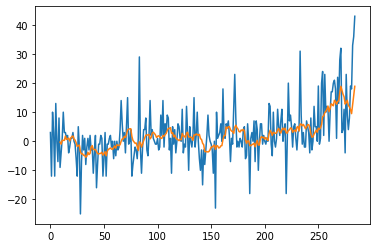

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(history)
plt.plot(pd.Series(history).rolling(10).mean())

In [6]:
agent.play(max_episodes=10)

Episode 0: 38.0
Episode 1: 66.0
Episode 2: 34.0
Episode 3: 18.0
Episode 4: 13.0
Episode 5: 42.0
Episode 6: 6.0
Episode 7: 52.0
Episode 8: 20.0
Episode 9: 18.0
